In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('datasets/Train.csv')

# ignore columns call_type	call_status	start_time	duration	end_time	display_location

df = df.drop(columns=['call_type', 'call_status', 'start_time', 'duration', 'end_time', 'display_location'])
df['conversions_calls'] = df['conversions_calls'].interpolate().fillna(df['conversions_calls'].interpolate().mean())


# Step 1: Identify numeric columns
numeric_columns = df.select_dtypes(include=['float64']).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())
df = df.dropna()


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 289526 entries, 0 to 289525
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   impressions         289526 non-null  float64
 1   clicks              289526 non-null  float64
 2   cost                289526 non-null  float64
 3   conversions         289526 non-null  float64
 4   ad_type             289526 non-null  object 
 5   currency            289526 non-null  object 
 6   ID                  289526 non-null  object 
 7   date                289526 non-null  object 
 8   impression_share    289526 non-null  float64
 9   conversions_calls   289526 non-null  float64
 10  headline1_len       289526 non-null  float64
 11  headline2_len       289526 non-null  float64
 12  ad_description_len  289526 non-null  float64
dtypes: float64(9), object(4)
memory usage: 30.9+ MB


In [6]:
df['currency'].unique(), df['currency'].nunique()

(array(['ZAR', 'USD'], dtype=object), 2)

In [7]:
# Example exchange rates for ZAR and USD
exchange_rates = {'USD': 1.0, 'ZAR': 0.071}  # 1 USD = 0.071 ZAR

# Function to convert cost to USD
def convert_to_usd(currency, cost):
    exchange_rate = exchange_rates.get(currency, 1.0)  # Default to 1.0 if currency not found
    return cost * exchange_rate

# Update 'cost' column with cost in USD
df['cost'] = df.apply(lambda row: convert_to_usd(row['currency'], row['cost']), axis=1)

# leaving currency column to determine locality


In [11]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

In [12]:
# display rows with ID ID_5e43c29e6279884e2827d894

df.loc[df['ID'] == 'ID_5e43c29e6279884e2827d894']['ad_type'].unique()

array(['EXPANDED_TEXT_AD', 'EXPANDED_DYNAMIC_SEARCH_AD'], dtype=object)

In [13]:
# encode currency, ad_type
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df['ad_type'] = le.fit_transform(df['ad_type'])
df['currency'] = le.fit_transform(df['currency'])

df.head()

,impressions,clicks,cost,conversions,ad_type,currency,ID,date,impression_share,conversions_calls,headline1_len,headline2_len,ad_description_len,year,month,day
0,142.0,15.0,240.903,0.0,1,1,ID_5da86e71bf5dee4cf5047046,2020-01-01,16.279669,0.0,2.0,5.0,11.0,2020,1,1
1,89.0,8.0,129.007,0.0,1,1,ID_5da86e71bf5dee4cf5047046,2020-01-01,16.279669,0.0,2.0,2.0,13.0,2020,1,1
2,59.0,8.0,123.753,0.0,1,1,ID_5da86e71bf5dee4cf5047046,2020-01-01,16.279669,0.0,2.0,2.0,10.0,2020,1,1
3,78.0,4.0,65.107,0.0,1,1,ID_5da86e71bf5dee4cf5047046,2020-01-01,16.279669,0.0,2.0,3.0,13.0,2020,1,1
4,20.0,1.0,15.407,0.0,1,1,ID_5da86e71bf5dee4cf5047046,2020-01-01,16.279669,0.0,2.0,2.0,13.0,2020,1,1


In [15]:
y = df['clicks']
X = df.drop(columns=['ID', 'clicks'])

X = X.drop(['date'], axis=1)

In [39]:
from sklearn.preprocessing import StandardScaler

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

In [40]:
_prepd_df = pd.concat([X, y], axis=1)

<Axes: >

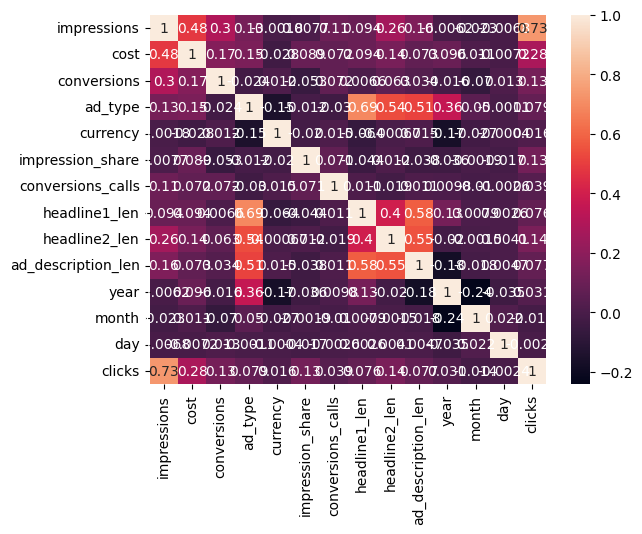

In [41]:
# plot correlation matrix
import seaborn as sns

corr = _prepd_df.corr()

sns.heatmap(corr, annot=True)

In [42]:
# from corr matrix, show features correlation with clicks

corr['clicks'].sort_values(ascending=False)


clicks                1.000000
impressions           0.734686
cost                  0.278523
headline2_len         0.144910
conversions           0.128776
impression_share      0.126332
ad_type               0.079040
ad_description_len    0.077180
headline1_len         0.075684
conversions_calls     0.038814
year                  0.030796
currency              0.016201
day                  -0.002419
month                -0.014417
Name: clicks, dtype: float64

In [43]:
# using the features with correlation > 0.1 from corr['clicks']

corr_features = corr['clicks'][corr['clicks'] > 0].index.drop('clicks')

In [44]:
%%capture
x = X[corr_features]
# y = df['clicks']

# # add date features for time series
x['year'] = X['year']
x['month'] = X['month']
x['day'] = X['day']

In [45]:
x.head()

,impressions,cost,conversions,ad_type,currency,impression_share,conversions_calls,headline1_len,headline2_len,ad_description_len,year,month,day
0,0.450480,0.136493,-0.076726,-0.268843,0.233002,-0.032266,-0.239826,-0.47456,1.269298,0.065160,-2.43374,-1.602911,-1.667347
1,0.105411,-0.072893,-0.076726,-0.268843,0.233002,-0.032266,-0.239826,-0.47456,-0.526729,0.508674,-2.43374,-1.602911,-1.667347
2,-0.089911,-0.082724,-0.076726,-0.268843,0.233002,-0.032266,-0.239826,-0.47456,-0.526729,-0.156597,-2.43374,-1.602911,-1.667347
3,0.033793,-0.192465,-0.076726,-0.268843,0.233002,-0.032266,-0.239826,-0.47456,0.071946,0.508674,-2.43374,-1.602911,-1.667347
4,-0.343829,-0.285467,-0.076726,-0.268843,0.233002,-0.032266,-0.239826,-0.47456,-0.526729,0.508674,-2.43374,-1.602911,-1.667347


In [46]:
# length check
len(x) == len(y)

True

In [47]:
# train test split
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# models

In [48]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, BayesianRidge
# from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

# Initialize and train models
models = {
    # "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.1, max_depth=3),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    # "LinearRegression": LinearRegression(),
    # "ElasticNet": ElasticNet(),
    # "BayesianRidge": BayesianRidge(),
    # "KNeighborsRegressor": KNeighborsRegressor(),
    # "DecisionTreeRegressor": DecisionTreeRegressor(),
    # "MLPRegressor": MLPRegressor()
}

# Train and evaluate models
results = {}
for name, model in models.items():
    print("Trainig ", name)
    try:
        model.fit(x_train, y_train)
        predictions = model.predict(x_test)
        mse = mean_squared_error(y_test, predictions)
        results[name] = mse
    except Exception as e:
        print(f"Error occurred while training {name}: {e}")
        results[name] = None  # Set MSE to None if an error occurs



# Print results
for name, mse in results.items():
    if mse is not None:
        rmse = sqrt(mse)
        print(f"{name} |--| Mean Squared Error: {mse}, |--| Root Mean Squared Error: {rmse}")
    else:
        print(f"{name} failed to train.")



Trainig  RandomForest
RandomForest |--| Mean Squared Error: 23.10860165095154, |--| Root Mean Squared Error: 4.807140693900226


# neural Net

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [52]:
# Define neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(x_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer with 1 neuron for regression
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')


c:\Users\Edgar\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [57]:
# Train model
history = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_split=0.2, verbose=1)


Epoch 1/10
5791/5791 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 30.5240 - val_loss: 32.1026
Epoch 2/10
5791/5791 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 26.2142 - val_loss: 35.1641
Epoch 3/10
5791/5791 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 22.7225 - val_loss: 41.6594
Epoch 4/10
5791/5791 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 23.8022 - val_loss: 31.2770
Epoch 5/10
5791/5791 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 25.8586 - val_loss: 33.6382
Epoch 6/10
5791/5791 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 21.3327 - val_loss: 32.4961
Epoch 7/10
5791/5791 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 24.4367 - val_loss: 42.7276
Epoch 8/10
5791/5791 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 25.3282 - val_loss: 33.3214
Epoch 9/10
5791/5791 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 23.5705 - val_loss: 33.5744
Epoch 10/10
5791/5791 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 24.1613 - val_loss: 36.2166


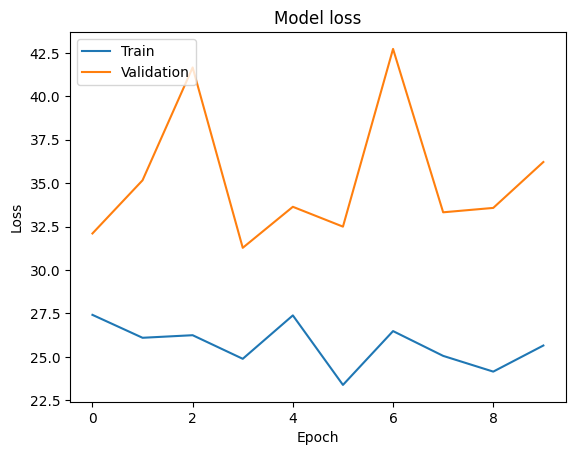

In [58]:
# model_choice = "RandomForest"
# model = models[model_choice]

import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Submision file Generation / inference


In [59]:
# model evaluation
from sklearn.metrics import mean_squared_error

# Evaluate model
y_pred = model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'RMSE: {rmse}')
print(f'MSE: {mse}')

1810/1810 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
RMSE: 5.280640109210272
MSE: 27.88515996300027


XGB:
RMSE: 7.566170321350423
MSE: 57.24693333168397

RANDOM FOREST REGRESSOR:
RMSE: 4.72865723929903
MSE: 22.36019928677512

In [61]:
# flatten y_pred to 1D array
y_pred = y_pred.flatten()
y_pred

array([5.6205716 , 1.9872364 , 0.54198015, ..., 7.0941143 , 3.70923   ,
       7.4657245 ], dtype=float32)

In [62]:
def extract_id_and_date(string):
    parts = string.split('_')
    id_str = parts[1]
    date_str = '_'.join(parts[2:])
    return "ID_" + id_str, pd.to_datetime(date_str, format='%Y_%m_%d')


In [63]:
# submission file
test_df = pd.read_csv('datasets/SampleSubmission.csv')

In [64]:
test_df['id'], test_df['date'] = zip(*test_df['ID'].map(extract_id_and_date))
test_df['end_date'] = test_df['date'] + pd.Timedelta(days=6)

In [65]:
test_df.head()

,ID,clicks,id,date,end_date
0,ID_5da86e71bf5dee4cf5047046_2024_01_22,0,ID_5da86e71bf5dee4cf5047046,2024-01-22,2024-01-28
1,ID_5da86e71bf5dee4cf5047046_2024_01_29,0,ID_5da86e71bf5dee4cf5047046,2024-01-29,2024-02-04
2,ID_5e43c29e6279884e2827d894_2024_02_21,0,ID_5e43c29e6279884e2827d894,2024-02-21,2024-02-27
3,ID_5e43c29e6279884e2827d894_2024_02_28,0,ID_5e43c29e6279884e2827d894,2024-02-28,2024-03-05
4,ID_5e4e7b480e374330ee151305_2023_12_04,0,ID_5e4e7b480e374330ee151305,2023-12-04,2023-12-10


In [66]:
test_row = test_df.iloc[0]
test_row['id']

'ID_5da86e71bf5dee4cf5047046'

In [67]:

XX = X.copy()

In [68]:
XX['date'] = pd.to_datetime(df['date'])

In [69]:
XX['ID'] = df['ID']

In [ ]:
XX.head(3)


In [70]:
def filter_df_by_id_or_date_range(df, id, start_date, end_date):
    """
    Filter DataFrame by ID or date range.

    Args:
    df (DataFrame): Input DataFrame to filter.
    id (str): ID to filter.
    start_date (str or Timestamp): Start date of the range.
    end_date (str or Timestamp): End date of the range.

    Returns:
    DataFrame: Filtered DataFrame containing rows within the specified ID or date range.
    """
    filtered = df[((df['ID'] == id) & (df['date'] >= start_date)) | ((df['ID'] == id) & (df['date'] <= end_date))]
    return filtered[x.columns]


# Iterate over each row in test_df
for index, test_row in test_df.iterrows():
    # Filter rows in XX based on the ID or date range from the current row
    filtered_df = filter_df_by_id_or_date_range(XX, test_row['id'], test_row['date'], test_row['end_date'])

    # Predict clicks for the filtered data
    clicks_predict = model.predict(filtered_df)
    clicks_predict = clicks_predict.flatten()
    # Calculate sum of clicks and update the 'clicks' column in test_df
    test_df.at[index, 'clicks'] = int(np.mean(clicks_predict))

print(test_df)


474/474 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
474/474 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

In [71]:
# count clicks with 0s
test_df[test_df['clicks'] == 0].shape[0]

10

In [72]:
test_df.head()

,ID,clicks,id,date,end_date
0,ID_5da86e71bf5dee4cf5047046_2024_01_22,7,ID_5da86e71bf5dee4cf5047046,2024-01-22,2024-01-28
1,ID_5da86e71bf5dee4cf5047046_2024_01_29,7,ID_5da86e71bf5dee4cf5047046,2024-01-29,2024-02-04
2,ID_5e43c29e6279884e2827d894_2024_02_21,2,ID_5e43c29e6279884e2827d894,2024-02-21,2024-02-27
3,ID_5e43c29e6279884e2827d894_2024_02_28,2,ID_5e43c29e6279884e2827d894,2024-02-28,2024-03-05
4,ID_5e4e7b480e374330ee151305_2023_12_04,3,ID_5e4e7b480e374330ee151305,2023-12-04,2023-12-10


In [ ]:
test_df.to_csv("nn_seq_attempt_attempt.csv", index=False)